In [1]:
import pandas as pd
import numpy as np

import os
import sys

In [2]:
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [4]:
import IPython.display as ipd
from IPython.display import Audio
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM,BatchNormalization , GRU,Attention
from tensorflow.keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

In [5]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


In [10]:
ravdess = "/Amisha/VTech/IntroToAI/speech-emotion-recognition/ravdess-data/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [16]:
Crema = "/Amisha/VTech/IntroToAI/speech-emotion-recognition/cremad/AudioWAV/"
Tess = "/Amisha/VTech/IntroToAI/speech-emotion-recognition/tess/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"

Preprocessing

RAVDESS
Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03) Speech (01) Fearful (06) Normal intensity (01) Statement "dogs" (02) 1st Repetition (01) 12th Actor (12) Female, as the actor ID number is even.

In [11]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # vì có 24 diễn viên khác nhau nên cần trích xuất file cho mỗi actor
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
    # phần thứ 3 trong mỗi file đại diện cho cảm xúc chính của file
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)

In [12]:
print(actor[0])
print(part[0])
print(file_path[0])

03-01-01-01-01-01-24.wav
03
/Amisha/VTech/IntroToAI/speech-emotion-recognition/ravdess-data/Actor_01/03-01-01-01-01-01-01.wav


In [13]:
# create dataframe for emotions
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for the file path
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# Convert numbers into real emotions 
# Because other datasets do not have calm, which is number 2, calm should be converted to neutral
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

  Emotions                                               Path
0  neutral  /Amisha/VTech/IntroToAI/speech-emotion-recogni...
1  neutral  /Amisha/VTech/IntroToAI/speech-emotion-recogni...
2  neutral  /Amisha/VTech/IntroToAI/speech-emotion-recogni...
3  neutral  /Amisha/VTech/IntroToAI/speech-emotion-recogni...
4  neutral  /Amisha/VTech/IntroToAI/speech-emotion-recogni...
______________________________________________
      Emotions                                               Path
1435  surprise  /Amisha/VTech/IntroToAI/speech-emotion-recogni...
1436  surprise  /Amisha/VTech/IntroToAI/speech-emotion-recogni...
1437  surprise  /Amisha/VTech/IntroToAI/speech-emotion-recogni...
1438  surprise  /Amisha/VTech/IntroToAI/speech-emotion-recogni...
1439  surprise  /Amisha/VTech/IntroToAI/speech-emotion-recogni...
_______________________________________________
neutral     288
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: Emotions, dtype: in

CREMA-D

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [14]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# create dataframe for emotions
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# create dataframe for path
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: Emotions, dtype: int64


TESS

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [17]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# create dataframe for emotions
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# create dataframe for path
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: Emotions, dtype: int64


Join dataset

In [18]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,/Amisha/VTech/IntroToAI/speech-emotion-recogni...
1,neutral,/Amisha/VTech/IntroToAI/speech-emotion-recogni...
2,neutral,/Amisha/VTech/IntroToAI/speech-emotion-recogni...
3,neutral,/Amisha/VTech/IntroToAI/speech-emotion-recogni...
4,neutral,/Amisha/VTech/IntroToAI/speech-emotion-recogni...


In [19]:
print(data_path.Emotions.value_counts())

happy       1863
sad         1863
angry       1863
fear        1863
disgust     1863
neutral     1775
surprise     592
Name: Emotions, dtype: int64


Data Visualization

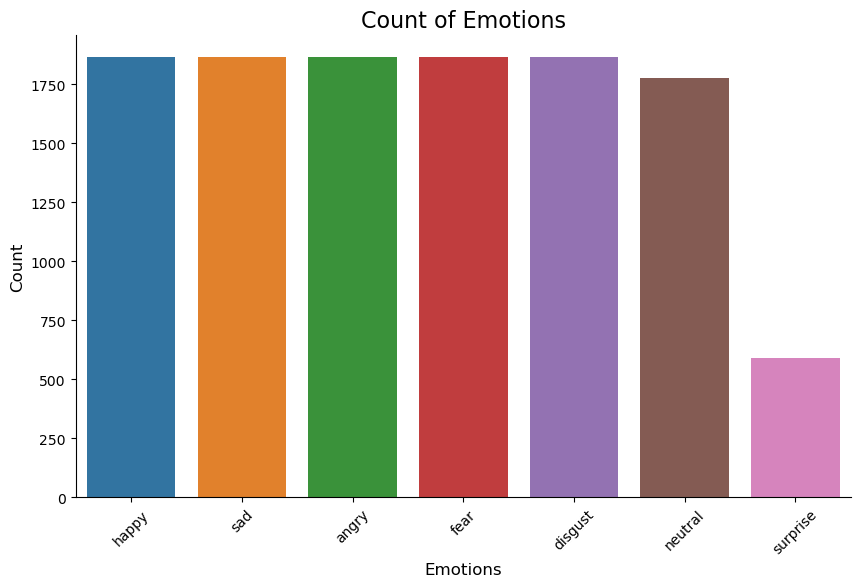

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of times each emotion appears
emotion_counts = data_path['Emotions'].value_counts()

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)  # Xoay nhãn trục x nếu cần thiết
sns.despine(top=True, right=True, left=False, bottom=False)

In [21]:
data_array, sample_rate = librosa.load(data_path['Path'].iloc[0])
sample_rate
#librosa.load is used to get sample rate and audio array

22050

In [22]:
ipd.Audio(data_array,rate=sample_rate)

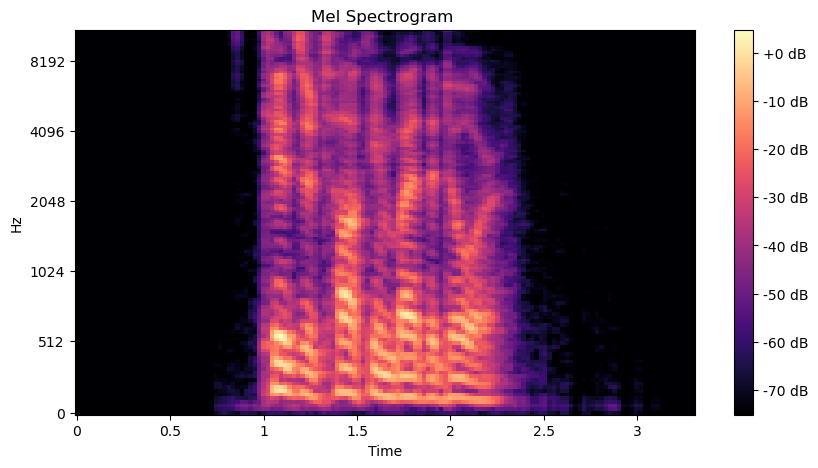

In [23]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
#A melspectrogram is a graph that represents sound as short walls measured in a mel space
spectrogram = librosa.feature.melspectrogram(y=data_array, sr=sample_rate, n_mels=128,fmax=5000) 
#Convert melspectrogram to Decibel units
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sample_rate, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

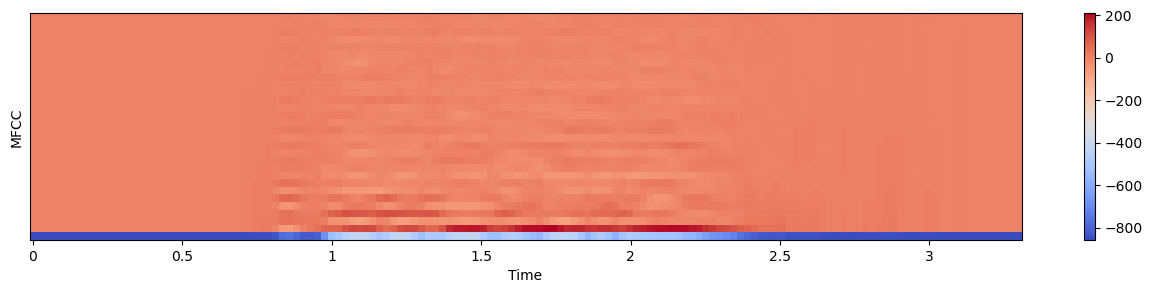

In [24]:
#Calculate mfcc characteristics (mel-frequency cpestral coeffcients)
mfcc = librosa.feature.mfcc(y=data_array, sr=sample_rate, n_mfcc=30)
'''
The returned result is a matrix of size (n_mfcc, T), where n_mfcc
is the number of MFCC coefficients and T is the number of time frames in the audio signal.
Each row of the matrix corresponds to an MFCC coefficient and each column corresponds to
a time frame. MFCC is often used to represent audio characteristics
and is commonly used in speech and music processing applications.

'''
# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data_array,rate=sample_rate)

Data Augmentation

In [25]:
# NOISE
def noise(data):
    noise_amp = 0.045*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH 
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

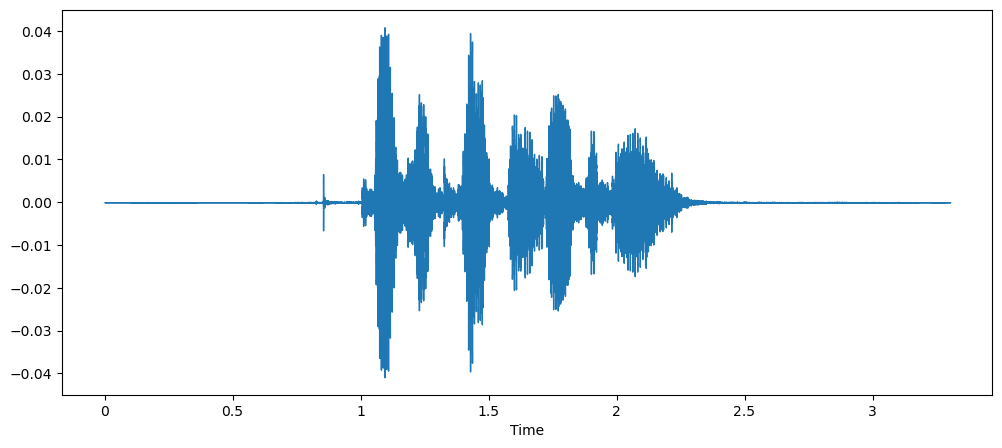

In [26]:
# original audio
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data_array, sr=sample_rate)
ipd.Audio(data_array,rate=sample_rate)

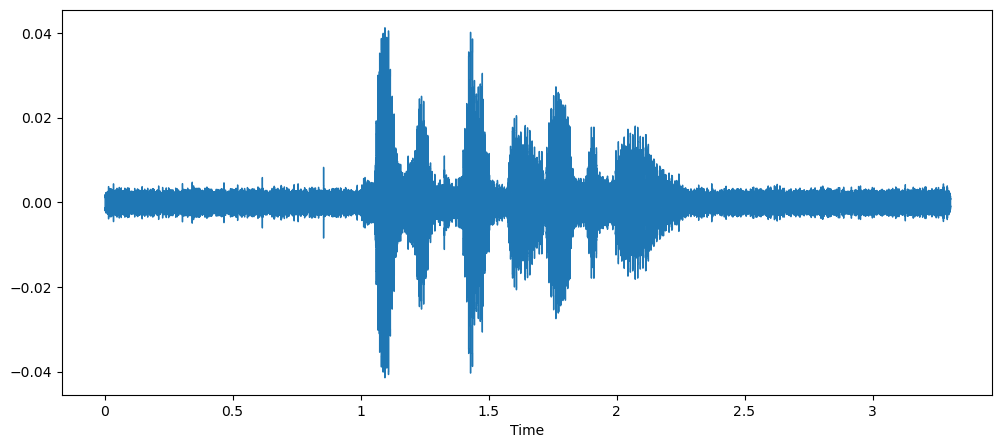

In [27]:
# AUDIO add noise
x = noise(data_array)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

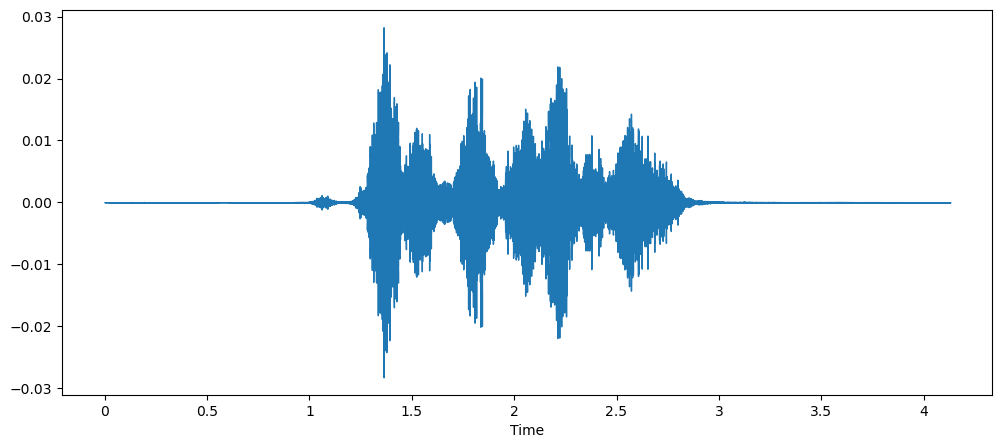

In [28]:
# audio stretch
x = stretch(data_array)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

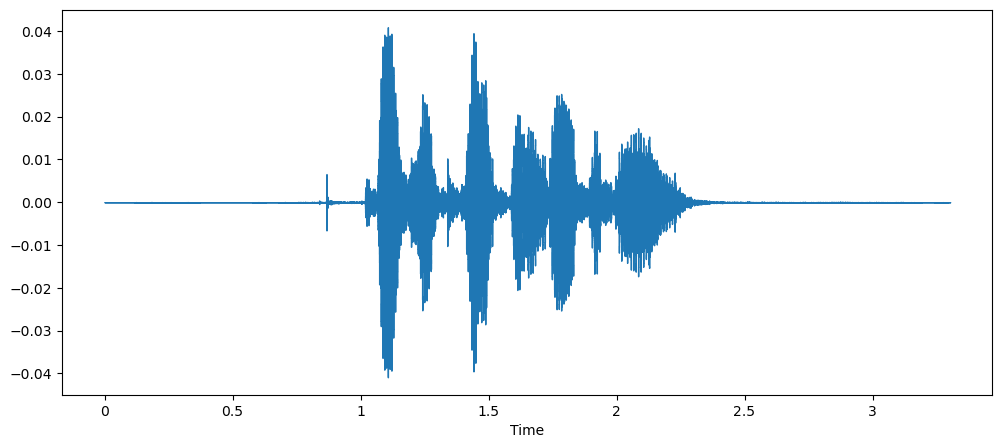

In [29]:
# audio pitch
x = shift(data_array)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

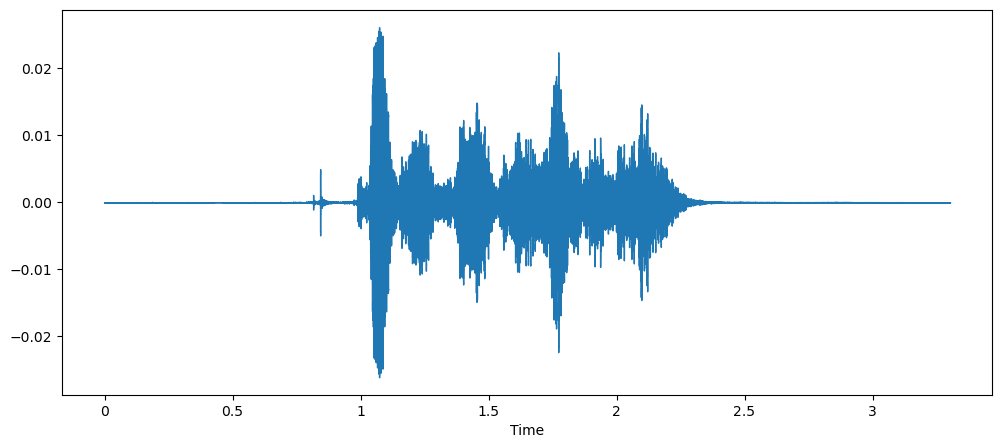

In [30]:
# audio
x = pitch(data=data_array,sampling_rate=sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

## Feature Extraction

In [32]:
# Calculate the threshold rate of audio data - returns a 1-dimensional array
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
# function to calculate root mean square error
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
#mfcc
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)
'''
feature extraction This function combines ZCR, RMSE, and MFCC features
to create a complete feature vector for the audio data.
'''
def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path = path,duration=duration,offset=offset)
    aud=extract_features(data) # feature extraction
    audio=np.array(aud) # convert features to array
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio


## Get feature

In [33]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


In [34]:
from joblib import Parallel, delayed  # Supports parallel wave calculations
import timeit
start = timeit.default_timer()
# get feature for each audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# run loops in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Fill in the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)   

Time:  322.99470910000673


In [35]:
len(X), len(Y), data_path.Path.shape

(46728, 46728, (11682,))

Saving features

In [36]:
emotions = pd.DataFrame(X)
emotions['Emotions'] = Y
emotions.to_csv('emotion.csv', index=False)
emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.000000,0.000000,0.064453,0.105469,0.125488,0.266113,0.350098,0.439941,0.547363,0.546387,...,0.089808,0.088329,0.086733,0.085019,0.083187,0.081227,0.079191,0.077032,0.074766,neutral
1,0.239746,0.358887,0.483398,0.506348,0.508301,0.503906,0.503906,0.479492,0.477539,0.487305,...,-2.653201,2.341406,8.362047,0.680340,0.928665,1.680899,-1.067404,-1.416415,2.018828,neutral
2,0.177734,0.268066,0.363770,0.380371,0.339355,0.323242,0.326660,0.337891,0.430664,0.503906,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
3,0.257324,0.384766,0.511230,0.505371,0.500977,0.504395,0.500488,0.514160,0.507324,0.503906,...,-3.613601,-1.111896,-2.737894,-8.467166,-2.296320,-2.656209,1.615473,-2.188312,-4.722026,neutral
4,0.130371,0.262207,0.422363,0.481445,0.394043,0.404297,0.391602,0.458984,0.554688,0.513672,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [38]:
Emotions = pd.read_csv('/Amisha/VTech/IntroToAI/speech-emotion-recognition/emotion.csv')

In [39]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [40]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(46728, 2377)

In [41]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

Data prepare

In [42]:
Y=Emotions['Emotions']
X= Emotions.drop('Emotions',axis= 1)

In [43]:
X.shape

(46728, 2376)

In [44]:
Y.shape

(46728,)

In [45]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [46]:
Y.shape

(46728, 7)

In [47]:
Y[0]

array([0., 0., 0., 0., 1., 0., 0.])

In [48]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=35,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 2376), (37382, 7), (9346, 2376), (9346, 7))

In [49]:
#reshape
X_train = x_train.to_numpy().reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.to_numpy().reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [50]:
X_train.shape

(37382, 2376, 1)

In [51]:
# scale data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 2376), (37382, 7), (9346, 2376), (9346, 7))

In [52]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((37382, 2376, 1), (37382, 7), (9346, 2376, 1), (9346, 7))

In [56]:
model_checkpoint = ModelCheckpoint('cnn.h5', monitor='val_accuracy', save_best_only=True)
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=5,verbose=1,factor=0.5,min_lr=0.00001)

## CNN Model

In [57]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2376, 512)         3072      
                                                                 
 batch_normalization_6 (Bat  (None, 2376, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 1188, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_7 (Bat  (None, 1188, 512)         2048      
 chNormalization)                                                
                                                      

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='cnn_model.png')

In [58]:
history=model.fit(x_traincnn, y_train, epochs=20, validation_data=(x_testcnn, y_test), batch_size=128,callbacks=[early_stop,lr_reduction,model_checkpoint])


Epoch 1/20
293/293 [==============================] - 4625s 16s/step - loss: 1.3868 - accuracy: 0.4769 - val_loss: 2.4505 - val_accuracy: 0.2374 - lr: 0.0010
Epoch 2/20
293/293 [==============================] - 3892s 13s/step - loss: 1.0761 - accuracy: 0.5808 - val_loss: 1.2391 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 3/20
293/293 [==============================] - 3683s 13s/step - loss: 0.9597 - accuracy: 0.6295 - val_loss: 1.0742 - val_accuracy: 0.5786 - lr: 0.0010
Epoch 4/20
293/293 [==============================] - 3665s 13s/step - loss: 0.8576 - accuracy: 0.6709 - val_loss: 0.8974 - val_accuracy: 0.6636 - lr: 0.0010
Epoch 5/20
293/293 [==============================] - 3587s 12s/step - loss: 0.7461 - accuracy: 0.7167 - val_loss: 0.8475 - val_accuracy: 0.6794 - lr: 0.0010
Epoch 6/20
293/293 [==============================] - 4668s 16s/step - loss: 0.6299 - accuracy: 0.7663 - val_loss: 0.8074 - val_accuracy: 0.7056 - lr: 0.0010
Epoch 7/20
293/293 [==============================] 